Imports

In [1]:
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
pd.set_option('display.max_columns', None)
from tensorflow import keras
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import *
from sklearn.model_selection import train_test_split 
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
cutoff = False
cutoff_threshold = 1
remove_zero = True

Load Data

In [3]:
df_test = pd.read_pickle("../TestDataFinalized.pkl")
df_train = pd.read_pickle("../TrainingDataFinalized.pkl")

Drop extra index column

In [7]:
df_train.drop(labels="index",axis=1,inplace=True)
df_test.drop(labels="index",axis=1,inplace=True)

In [8]:
df_train_og = df_train.copy()

Split into test and train data

In [9]:
y_train = df_train['Litres']
#y_test = df_test['Litres']

X_train = df_train.drop(labels=['Litres','WeekStarting',"Customer",
       #,'WeekNumber'
       #,'Akdeniz Bölgesi', 'Doğu Anadolu Bölgesi','Ege Bölgesi', 'Güneydoğu Anadolu Bölgesi', 
       #'Karadeniz Bölgesi', 'Marmara Bölgesi', 'İç Anadolu Bölgesi'
       ],axis=1)

X_test = df_test.drop(labels=['Litres','WeekStarting',"Customer",
       #,'WeekNumber'
       #,'Akdeniz Bölgesi', 'Doğu Anadolu Bölgesi',
       #'Ege Bölgesi', 'Güneydoğu Anadolu Bölgesi', 'Karadeniz Bölgesi',
       #'Marmara Bölgesi', 'İç Anadolu Bölgesi'
       ],axis=1)


In [10]:
df_train.columns

Index(['Customer', 'WeekStarting', 'Litres', 'WeekendHolidays',
       'WeekdayHolidays', 'WeekNumber', 'Price(t-1)', 'Price%Change',
       'NewCars', 'GDPGrowth%', 'MoMInflation%', 'WoWUSDChange%',
       'Litres(w-51)', 'Litres(w-52)', 'Litres(w-53)', 'Litres(w-54)',
       'Litres(w-51_average_city)', 'Litres(w-52_average_city)',
       'Litres(w-53_average_city)', 'Litres(w-54_average_city)',
       'Litres(w-51_average_area)', 'Litres(w-52_average_area)',
       'Litres(w-53_average_area)', 'Litres(w-54_average_area)', 'Benzin',
       'Motorin', 'Akdeniz Bölgesi', 'Doğu Anadolu Bölgesi', 'Ege Bölgesi',
       'Güneydoğu Anadolu Bölgesi', 'Karadeniz Bölgesi', 'Marmara Bölgesi',
       'İç Anadolu Bölgesi', 'Autumn', 'Fall', 'Summer', 'Winter'],
      dtype='object')

Performance Plotting Functions

In [11]:
def model_evolution_loss(history,y_lim1=0,y_lim2=2):  
    # summarize history for loss
    plt.ylim(y_lim1,y_lim2)
    plt.plot(history.history['val_loss'],color='r',label="Validation")
    plt.plot(history.history['loss'],color='b',label="Training")
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

# Evaluate accuracy on training set
def test_set_evalution(model, X_train, X_valid, y_train, y_valid,X_train_test,y_train_test):
    print("Train set evaluation:", model.evaluate(X_train,y_train))
    print("Valid set evaluation:", model.evaluate(X_valid,y_valid))
    print("Test set evaluation:", model.evaluate(X_train_test,y_train_test))

In [12]:
# SO we dont get errors
df_train.loc[df_train["Litres"] == 0, "Litres"] = 0.01

Optionally remove weeks with zreo orders

In [13]:
remove_zero = False
if remove_zero == True:
    df_train = df_train[df_train["Litres"] > 1]

cutoff = False
cutoff_threshold = 1000

if cutoff == True:
    df_train = df_train[df_train["Litres"] > cutoff_threshold]


In [14]:
df_train[df_train["Litres"] < 10000]

,Customer,WeekStarting,Litres,WeekendHolidays,WeekdayHolidays,WeekNumber,Price(t-1),Price%Change,NewCars,GDPGrowth%,MoMInflation%,WoWUSDChange%,Litres(w-51),Litres(w-52),Litres(w-53),Litres(w-54),Litres(w-51_average_city),Litres(w-52_average_city),Litres(w-53_average_city),Litres(w-54_average_city),Litres(w-51_average_area),Litres(w-52_average_area),Litres(w-53_average_area),Litres(w-54_average_area),Benzin,Motorin,Akdeniz Bölgesi,Doğu Anadolu Bölgesi,Ege Bölgesi,Güneydoğu Anadolu Bölgesi,Karadeniz Bölgesi,Marmara Bölgesi,İç Anadolu Bölgesi,Autumn,Fall,Summer,Winter
21,10048261,2015-06-15,5088.00,0.0,0.0,-0.136737,-1.104813,-0.0084,-0.957270,-0.237204,-0.260466,-0.401656,0.119187,0.277084,0.031551,0.073388,-0.151287,0.227781,0.008800,-0.019747,0.370006,0.208775,0.225935,-0.102171,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
22,10048261,2015-06-29,0.01,0.0,0.0,-0.001426,-1.104813,-0.0084,-0.950081,-0.237204,-0.260466,0.189537,0.016364,-0.062488,0.122169,0.280834,-0.009199,-0.411007,-0.148335,0.233351,0.084909,-0.322635,0.375716,0.215204,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
203,10048263,2015-01-19,9442.00,0.0,0.0,-1.557495,-1.557341,-0.0084,-0.990184,-0.404855,0.349884,0.266315,-0.970394,-0.086855,-0.125379,-0.240462,-0.266845,-0.096913,-0.244779,-0.320334,-0.266662,0.063747,-0.009526,-0.253587,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
491,10048264,2016-12-26,9551.00,1.0,0.0,1.689953,-0.670755,-0.0084,-0.924100,-1.382823,0.054279,-0.033120,-0.377127,-0.459838,-0.460799,-0.379051,-0.442146,-0.344447,-0.448773,-0.399218,-0.291678,-0.083890,0.119941,0.127856,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
494,10048264,2017-01-30,0.01,0.0,0.0,-1.489840,-0.495284,-0.0084,-0.913881,-1.382823,0.426444,-1.933383,-0.498886,-0.460738,-0.374895,-0.458825,0.006801,-0.448598,-0.274401,-0.494141,0.257490,-0.274224,-0.029580,0.047494,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380864,12655800,2018-11-19,5001.00,0.0,0.0,1.351677,1.333300,-0.0084,-0.562529,0.573113,3.410142,-0.470756,-0.624394,-0.588118,-0.630592,-0.564708,-0.815959,-0.769308,-0.827033,-0.738022,-1.077736,-0.992247,-1.064174,-0.982869,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
380867,12655800,2018-12-10,8541.00,0.0,0.0,1.554642,0.880772,-0.0084,-0.602337,0.573113,3.410142,0.285510,-0.596617,-0.581050,-0.628299,-0.621729,-0.778766,-0.759827,-0.823953,-0.814597,-1.030673,-1.002712,-1.038321,-1.077681,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
380880,12663274,2018-12-17,9620.00,0.0,0.0,1.622298,0.982360,-0.0084,-1.078365,-0.432797,3.033724,-0.478434,-0.776619,-0.775231,-0.774434,-0.774372,-1.019783,-1.020302,-1.020210,-1.019587,-1.086419,-1.175195,-1.102357,-1.155318,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
380883,12663344,2018-12-17,9701.00,0.0,0.0,1.622298,0.963889,-0.0084,-1.078365,-0.432797,3.033724,-0.478434,-0.815327,-0.793793,-0.736127,-0.849494,-1.071611,-1.045200,-0.968765,-1.120471,-1.086419,-1.175195,-1.102357,-1.155318,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Train Validation split

In [15]:
from sklearn.model_selection import train_test_split 
#X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train,test_size=0.1)

# split the year 2018 into the validation set
valid_date_1 = '2017-01-01'
valid_date_2 ='2017-07-01'

test_date_1 = '2016-07-01'
test_date_2 = '2017-01-01'

valid_index = df_train[(df_train.WeekStarting >= valid_date_1) & (df_train.WeekStarting <= valid_date_2)].index
test_index = df_train[(df_train.WeekStarting >= test_date_1) & (df_train.WeekStarting < test_date_2)].index

#train_index = df_train[(df_train.WeekStarting >= '2017-01-01') & (df_train.WeekStarting <= '2017-07-01')].index

X_full = X_train.copy()
y_full = X_train.copy()

X_valid= X_train[X_train.index.isin(valid_index)]
y_valid = y_train[y_train.index.isin(valid_index)]

X_train_test = X_train[X_train.index.isin(test_index)]
y_train_test = y_train[y_train.index.isin(test_index)]

#X_train = X_train[X_train.index.isin(train_index)]
#y_train = y_train[y_train.index.isin(train_index)]


X_train = X_train[~(X_train.index.isin(test_index)) & ~(X_train.index.isin(valid_index))]
y_train = y_train[~(y_train.index.isin(test_index)) & ~(y_train.index.isin(valid_index))]




In [16]:
n_input = X_train.shape[1]
n_input

34

Design NN

In [17]:
from tensorflow.keras.metrics import RootMeanSquaredError


model = Sequential()

# hidden layers

model.add(Dense(units=32, activation='relu', input_dim=n_input))
model.add(Dense(units=16,activation='relu'))
model.add(Dense(units=16,activation='relu'))
model.add(Dense(units=8,activation='relu'))
model.add(Dense(units=8,activation='relu'))

# final layer
model.add(Dense(units=1,activation='relu'))

# Define custom optmizer?
#from keras.optimizers import SGD
#opt = SGD(learning_rate=0.1, momentum=0.9)

# Compile model
model.compile(loss="MeanSquaredLogarithmicError", optimizer='SGD',metrics=["RootMeanSquaredError"])
#model.compile(loss="MeanSquaredError", optimizer='adam',metrics=["MeanSquaredLogarithmicError","RootMeanSquaredError"])
# Train NN with Early stopping on valid
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size = 1024,validation_data=(X_valid,y_valid), verbose=1,callbacks=[early_stopping])


Epoch 1/100
279/279 [==============================] - 6s 9ms/step - loss: 10.1520 - root_mean_squared_error: 55103.0234 - val_loss: 2.1526 - val_root_mean_squared_error: 47948.8438
Epoch 2/100
279/279 [==============================] - 2s 7ms/step - loss: 1.8692 - root_mean_squared_error: 42727.4023 - val_loss: 1.4844 - val_root_mean_squared_error: 38690.6836
Epoch 3/100
279/279 [==============================] - 2s 8ms/step - loss: 1.5764 - root_mean_squared_error: 35163.0938 - val_loss: 1.3108 - val_root_mean_squared_error: 33151.3125
Epoch 4/100
279/279 [==============================] - 3s 10ms/step - loss: 1.4645 - root_mean_squared_error: 30429.0625 - val_loss: 1.2461 - val_root_mean_squared_error: 29567.3535
Epoch 5/100
279/279 [==============================] - 2s 9ms/step - loss: 1.4076 - root_mean_squared_error: 27352.9668 - val_loss: 1.2162 - val_root_mean_squared_error: 27239.0176
Epoch 6/100
279/279 [==============================] - 2s 7ms/step - loss: 1.3714 - root_mean

In [18]:
history.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])

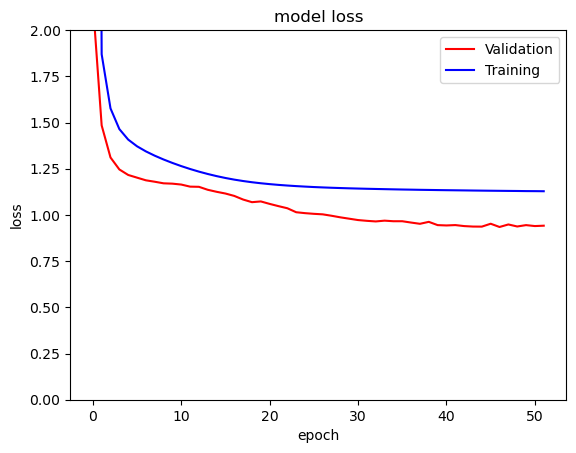

In [19]:
# Plot model evolution
model_evolution_loss(history)

In [20]:
# print metrics
test_set_evalution(model, X_train, X_valid, y_train, y_valid,X_train_test,y_train_test)
model.evaluate(X_train_test,y_train_test)

8912/8912 [==============================] - 22s 2ms/step - loss: 1.1300 - root_mean_squared_error: 16595.1074
Train set evaluation: [1.1299693584442139, 16595.107421875]
1478/1478 [==============================] - 4s 2ms/step - loss: 0.9347 - root_mean_squared_error: 16437.1270
Valid set evaluation: [0.9346898794174194, 16437.126953125]
1513/1513 [==============================] - 4s 2ms/step - loss: 0.9649 - root_mean_squared_error: 18567.9570
Test set evaluation: [0.9648528099060059, 18567.95703125]
1513/1513 [==============================] - 4s 3ms/step - loss: 0.9649 - root_mean_squared_error: 18567.9570


[0.9648528099060059, 18567.95703125]

Check that my X_test is the same order as as the original test data

In [21]:
df_test_og = pd.read_csv(r"C:\Users\feyzi\OneDrive - Imperial College London\Programming\ShellDatathonNew\ShellDatathon\OriginalData\test.csv")

In [22]:
(df_test_og.Customer == df_test.Customer).sum()

108472

### Plot the results from the validation dataset

In [23]:
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
y_train_test_pred = model.predict(X_train_test)


X_train["Litres(actual)"] = y_train.copy()
X_train["Litres(predicted)"] = y_train_pred.copy()
X_valid["Litres(actual)"] = y_valid.copy()
X_valid["Litres(predicted)"] = y_valid_pred.copy()
X_train_test["Litres(actual)"] = y_train_test.copy()
X_train_test["Litres(predicted)"] = y_train_test_pred.copy()

df = pd.concat([X_train,X_valid, X_train_test])
df["WeekStarting"] = df_train["WeekStarting"].copy()

1513/1513 [==============================] - 2s 1ms/step


Plot

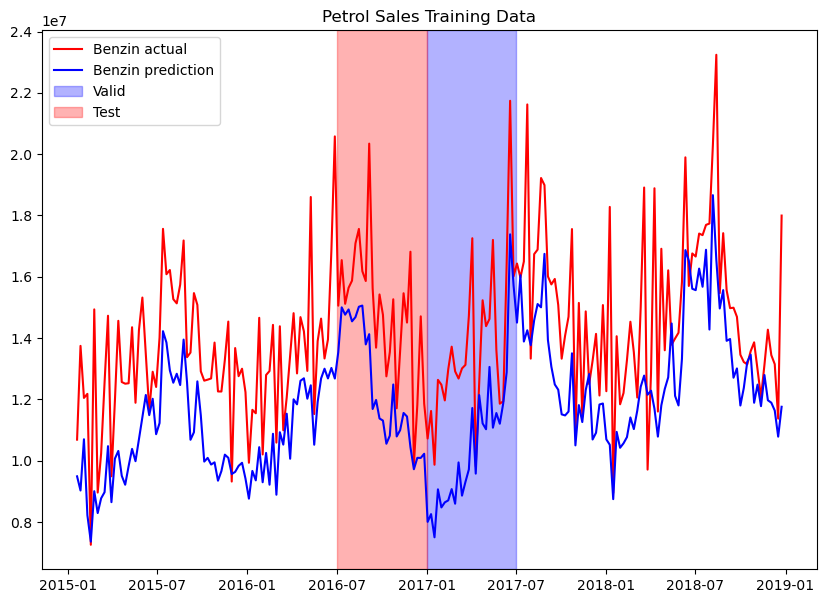

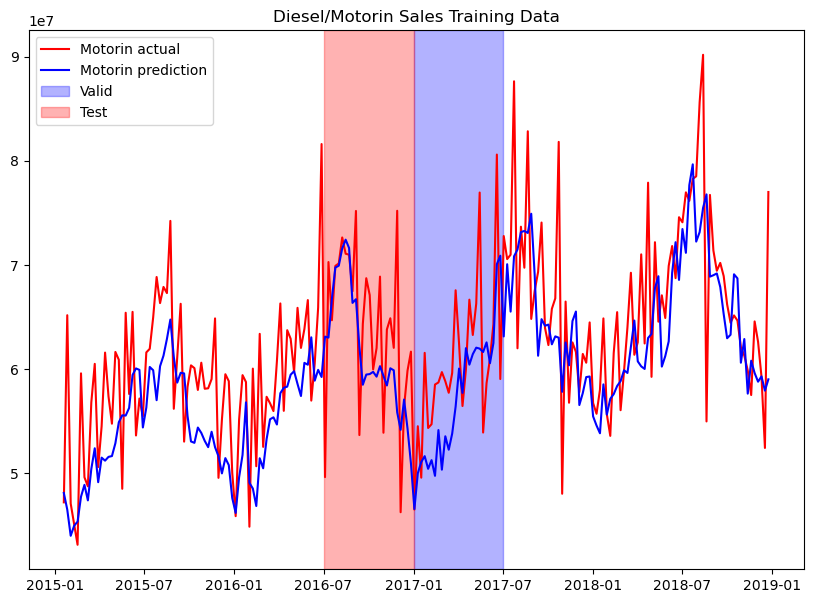

In [24]:
#Benzin
fig, ax = plt.subplots()
fig.set_size_inches(10, 7, forward=True)

df1 = df[df["Benzin"] == 1]
df1 = df1.groupby(by=["WeekStarting"],axis=0).sum()
df1.reset_index(inplace=True)

benzin_sales_actual = df1["Litres(actual)"]
benzin_sales_pred = df1["Litres(predicted)"]
dates = df1["WeekStarting"]

ax.plot(dates,benzin_sales_actual,color='r',label="Benzin actual")
ax.plot(dates,benzin_sales_pred,color='b',label="Benzin prediction")
ax.set_title("Petrol Sales Training Data")
ax.legend()

# highlight a time range
ax.axvspan(valid_date_1, valid_date_2, color="blue", alpha=0.3,label="Valid")
ax.axvspan(test_date_1, test_date_2, color="red", alpha=0.3,label="Test")
ax.legend()

#Motorin
fig, ax = plt.subplots()
fig.set_size_inches(10, 7, forward=True)

df2 = df[df["Motorin"] == 1]
df2 = df2.groupby(by=["WeekStarting"],axis=0).sum()
df2.reset_index(inplace=True)

motorin_sales_actual = df2["Litres(actual)"]
motorin_sales_pred = df2["Litres(predicted)"]
dates = df2["WeekStarting"]

ax.plot(dates,motorin_sales_actual,color='r',label="Motorin actual")
ax.plot(dates,motorin_sales_pred,color='b',label="Motorin prediction")
ax.legend()

# highlight a time range
ax.axvspan(valid_date_1, valid_date_2, color="blue", alpha=0.3,label="Valid")
ax.axvspan(test_date_1, test_date_2, color="red", alpha=0.3,label="Test")
ax.set_title("Diesel/Motorin Sales Training Data")
ax.legend()

#plt.plot(dates,motorin_sales/4.2)

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                1120      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dense_4 (Dense)             (None, 8)                 72        
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,137
Trainable params: 2,137
Non-trainabl

## Now do prediction

In [26]:
y_test_pred = model.predict(X_test) 

3390/3390 [==============================] - 6s 2ms/step


In [27]:
y_test_pred

array([[31474.38 ],
       [30405.51 ],
       [30860.225],
       ...,
       [ 5906.882],
       [ 5598.586],
       [ 4056.31 ]], dtype=float32)

In [28]:
n = len(y_test_pred)
n

108472

In [29]:
index_values = np.linspace(0,n-1,n)
df_pred = pd.DataFrame(data = y_test_pred)
df_pred.columns=["Litres"]
df_pred.index.name = 'index'

In [30]:
df_pred.to_csv(r"C:\Users\feyzi\OneDrive - Imperial College London\Programming\ShellDatathonNew\ShellDatathon\SubmissionAttempts\MyTestSubmission.csv")

Plot the weekly liter sum to see estimate

In [31]:
df_test.Litres = y_test_pred

In [32]:
df = pd.concat([df_train_og,df_test])

C:\Users\feyzi\AppData\Local\Temp\ipykernel_13204\1437299923.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df1 = df1.groupby(by=["WeekStarting"],axis=0).sum()
C:\Users\feyzi\AppData\Local\Temp\ipykernel_13204\1437299923.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2 = df2.groupby(by=["WeekStarting"],axis=0).sum()


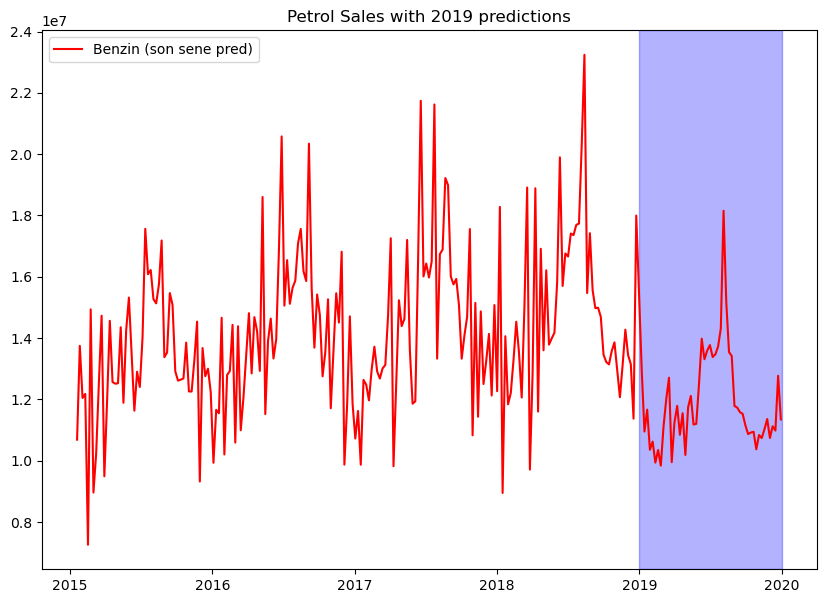

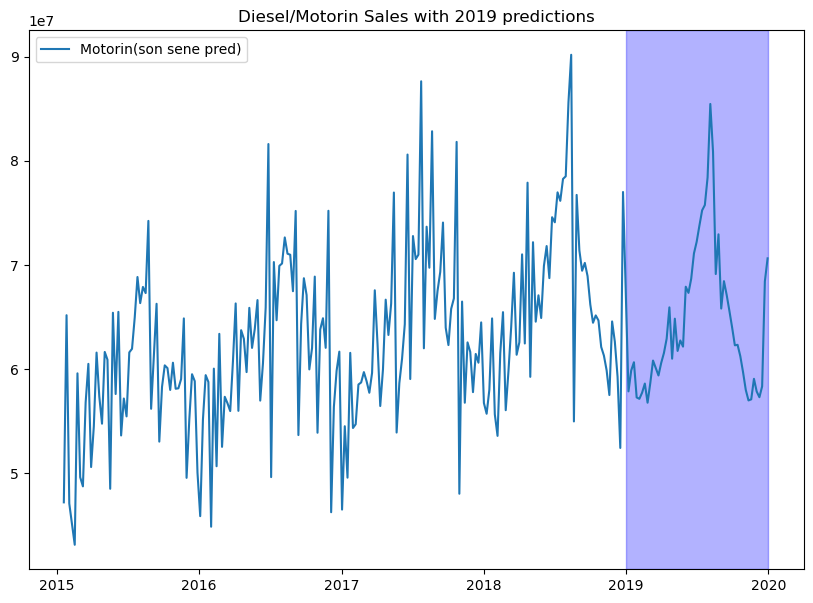

In [33]:
#Benzin


fig, ax = plt.subplots()
fig.set_size_inches(10, 7, forward=True)
df1 = df[df["Benzin"] == 1]
df1 = df1.groupby(by=["WeekStarting"],axis=0).sum()
df1.reset_index(inplace=True)
benzin_sales = df1.Litres
dates = df1["WeekStarting"]
plt.plot(dates,benzin_sales,color='r',label="Benzin (son sene pred)")
ax.set_title("Petrol Sales with 2019 predictions")
ax.legend()
ax.axvspan("2019-01-01", "2020-01-01", color="blue", alpha=0.3)

fig, ax = plt.subplots()
fig.set_size_inches(10, 7, forward=True)
df2 = df[df["Motorin"] == 1]
df2 = df2.groupby(by=["WeekStarting"],axis=0).sum()
df2.reset_index(inplace=True)
motorin_sales = df2.Litres
dates = df2["WeekStarting"]
plt.plot(dates,motorin_sales,label="Motorin(son sene pred)")
ax.set_title("Diesel/Motorin Sales with 2019 predictions")
ax.legend()

# highlight a time range
ax.axvspan("2019-01-01", "2020-01-01", color="blue", alpha=0.3)

#plt.plot(dates,motorin_sales/4.2)